<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/node_postprocessor/colpalirerank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reranking using ColPali, Cohere Reranker and Multi-Modal Embeddings

[ColPali](https://huggingface.co/vidore/colpali-v1.2): ColPali it is a model based on a novel model architecture and training strategy based on Vision Language Models (VLMs), to efficiently index documents from their visual features.

In this notebook, we will demonstrate the usage of ColPali as a reranker on top of retrieved images using Cohere Multi-Modal embeddings.

For the demonstration, here are the steps:

1. Download text, images, and raw PDF files from related Wikipedia articles.
2. Build a Multi-Modal index for both texts and images using Cohere Multi-Modal Embeddings.
3. Retrieve relevant text and images simultaneously using a Multi-Modal Retriever for a query.
4. Rerank text nodes using Cohere Reranker and image nodes using ColPali.
5. Generate responses using the Multi-Modal Query Engine for a query using gpt-4o Multi-Modal LLM.

### Installation

We will use Cohere MultiModal embeddings for retrieval, ColPali as reranker for image nodes, Cohere reranker for text nodes, Qdrant vector-store and OpenAI MultiModal LLM for response generation.

In [ ]:
%pip install llama-index-postprocessor-colpali-rerank
%pip install llama-index-postprocessor-cohere-rerank
%pip install llama-index-embeddings-cohere
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-multi-modal-llms-openai

### Setup API Keys

Cohere - MultiModal Retrieval

OpenAI - MultiModal LLM.

In [ ]:
import os

os.environ["COHERE_API_KEY"] = "<YOUR COHERE API KEY>"

os.environ["OPENAI_API_KEY"] = "<YOUR OPENAI API KEY>"

### Utils

1. `get_wikipedia_images`: Get the image URLs from the Wikipedia page with the specified title.
2. `plot_images`: Plot the images in the specified list of image paths.
3. `delete_large_images`: Delete images larger than 5 MB in the specified directory.

**NOTE**: Cohere API accepts images of size less than 5MB.

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import urllib.request
import os


def get_wikipedia_images(title):
    """
    Get the image URLs from the Wikipedia page with the specified title.
    """
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls


def plot_images(image_paths):
    """
    Plot the images in the specified list of image paths.
    """
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


def delete_large_images(folder_path):
    """
    Delete images larger than 5 MB in the specified directory.
    """
    # List to hold the names of deleted image files
    deleted_images = []

    # Iterate through each file in the directory
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(
            (".png", ".jpg", ".jpeg", ".gif", ".bmp")
        ):
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            # Get the size of the file in bytes
            file_size = os.path.getsize(file_path)
            # Check if the file size is greater than 5 MB (5242880 bytes) and remove it
            if file_size > 5242880:
                os.remove(file_path)
                deleted_images.append(file_name)
                print(
                    f"Image: {file_name} was larger than 5 MB and has been deleted."
                )

/Users/ravithejad/Desktop/llamaindex/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Donwload text and images from Wikipedia

We will download text and images associated from following wikipedia pages.

1. Audi e-tron
2. Ford Mustang
3. Porsche Taycan


In [ ]:
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 10

wiki_titles = {
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        list_img_urls = get_wikipedia_images(title)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

### Delete larger image files

Cohere MultiModal Embedding model accepts less than 5MB file, so here we delete the larger image files.

In [ ]:
delete_large_images(data_path)

Image: 8.jpg was larger than 5 MB and has been deleted.
Image: 13.jpg was larger than 5 MB and has been deleted.
Image: 11.jpg was larger than 5 MB and has been deleted.
Image: 21.jpg was larger than 5 MB and has been deleted.
Image: 23.jpg was larger than 5 MB and has been deleted.
Image: 32.jpg was larger than 5 MB and has been deleted.
Image: 19.jpg was larger than 5 MB and has been deleted.
Image: 4.jpg was larger than 5 MB and has been deleted.
Image: 5.jpg was larger than 5 MB and has been deleted.
Image: 7.jpg was larger than 5 MB and has been deleted.
Image: 6.jpg was larger than 5 MB and has been deleted.
Image: 1.jpg was larger than 5 MB and has been deleted.


### Set Embedding Model and LLM.

Cohere MultiModal Embedding model for retrieval and OpenAI MultiModal LLM for response generation.

In [ ]:
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import Settings

Settings.embed_model = CohereEmbedding(
    api_key=os.environ["COHERE_API_KEY"],
    model_name="embed-english-v3.0",  # current v3 models support multimodal embeddings
)

gpt_4o = OpenAIMultiModal(model="gpt-4o", max_new_tokens=4096)

### Setup Cohere Reranker

In [ ]:
from llama_index.postprocessor.cohere_rerank import CohereRerank

cohere_rerank = CohereRerank(api_key=os.environ["COHERE_API_KEY"], top_n=3)

### Setup ColPali Reranker

In [ ]:
from llama_index.postprocessor.colpali_rerank import ColPaliRerank

colpali_reranker = ColPaliRerank(
    top_n=3,
    model="vidore/colpali-v1.2",
    keep_retrieval_score=True,
    device="cuda",  # or "cpu" or "cuda:0" or "mps" for Apple
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/ravithejad/Desktop/llamaindex/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


### Load the data

We will load the downloaded text and image data.

In [ ]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

### Setup Qdrant VectorStore

We will use Qdrant vector-store for storing image and text embeddings and associated metadata.

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext

import qdrant_client

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

### Create MultiModalVectorStoreIndex.

In [ ]:
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    image_embed_model=Settings.embed_model,
)

### Test the Retrieval

Here we create a retriever and test it out.

In [ ]:
retriever_engine = index.as_retriever(
    similarity_top_k=6, image_similarity_top_k=6
)

In [ ]:
query = "Which models of Porsche are discussed here?"
retrieval_results = retriever_engine.retrieve(query)

#### Inspect the retrieval results

**Node ID:** e37183fe-8b2b-4bc5-b856-0a2b0221b011<br>**Similarity:** 0.4906621738377948<br>**Text:** === Aerodynamics ===
The Taycan Turbo has a drag coefficient of Cd=0.22, which the manufacturer claims is the lowest of any current Porsche model. The Turbo S model has a slightly higher drag coeff...<br>

**Node ID:** d40676ea-00fa-4d45-8149-c22129115d44<br>**Similarity:** 0.4863016369562377<br>**Text:** The Porsche Taycan is a battery electric luxury sports sedan and shooting brake car produced by German automobile manufacturer Porsche. The concept version of the Taycan named the Porsche Mission E...<br>

**Node ID:** 6e989ddd-581d-4391-8f51-66f627b5baae<br>**Similarity:** 0.4680214751437455<br>**Text:** === Porsche Mission E Cross Turismo ===
The Porsche Mission E Cross Turismo previewed the Taycan Cross Turismo, and was presented at the 2018 Geneva Motor Show. The design language of the Mission E...<br>

**Node ID:** 17e0044d-c6a2-4387-b481-08003706333b<br>**Similarity:** 0.4333677171313131<br>**Text:** == Specifications ==


=== Chassis ===
The Taycan's body is mainly steel and aluminium joined by different bonding techniques. The body's B pillars, side roof frame and seat cross member are made f...<br>

**Node ID:** 237d74ca-ad9e-413b-a897-295fc657318d<br>**Similarity:** 0.4244636106388237<br>**Text:** === Range and charging ===
The EPA lists the Taycan 4S' range at 203 mi (327 km) with a consumption of 69 mpg‑e (49 kWh/100 mi). However, the car's range depends on how it is driven and what drivin...<br>

**Node ID:** 0ce4a54a-1660-45f2-b84c-024be65434ed<br>**Similarity:** 0.39880809672817724<br>**Text:** === e-tron GT (2021) ===

The e-tron GT is a four-door all-electric grand tourer. The concept model was showcased at the 2018 Los Angeles Auto Show. It is built on the same platform as the Porsche ...<br>

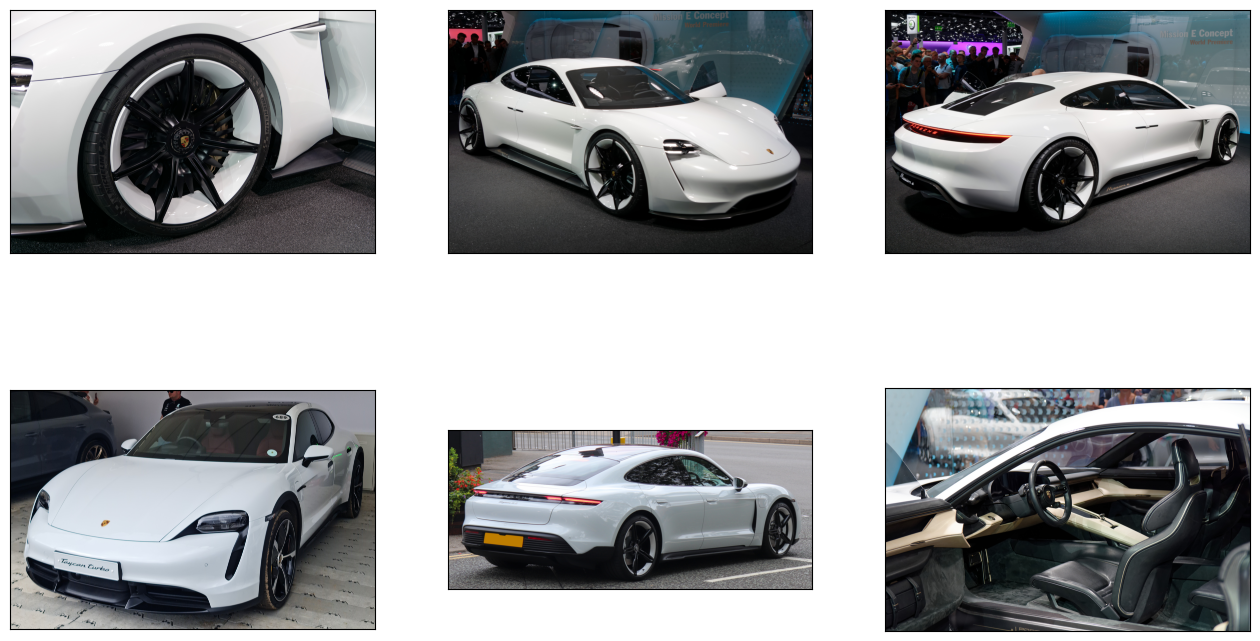

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Test the MultiModal QueryEngine

We will create a `QueryEngine` by using the above `MultiModalVectorStoreIndex`.

In [ ]:
from llama_index.core.query_engine import (
    CustomQueryEngine,
    SimpleMultiModalQueryEngine,
)
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import (
    ImageNode,
    NodeWithScore,
    MetadataMode,
    TextNode,
)
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.core.indices.query.schema import QueryBundle
from typing import Optional

QA_PROMPT_TMPL = """\
Below we give parsed text and images as context.

Use both the parsed text and images to answer the question. 

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: OpenAIMultiModal

    def __init__(
        self, qa_prompt: Optional[PromptTemplate] = None, **kwargs
    ) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        image_nodes = [n for n in nodes if isinstance(n.node, ImageNode)]
        text_nodes = [n for n in nodes if isinstance(n.node, TextNode)]

        # Make QueryBundle
        query_bundle = QueryBundle(query_str)

        # reranking text nodes
        reranked_text_nodes = cohere_rerank.postprocess_nodes(
            text_nodes, query_bundle
        )

        # reranking image nodes
        reranked_image_nodes = colpali_reranker.postprocess_nodes(
            image_nodes, query_bundle
        )

        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [
                r.get_content(metadata_mode=MetadataMode.LLM)
                for r in reranked_text_nodes
            ]
        )
        fmt_prompt = self.qa_prompt.format(
            context_str=context_str, query_str=query_str
        )

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[n.node for n in reranked_image_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={
                "text_nodes": reranked_text_nodes,
                "image_nodes": reranked_image_nodes,
            },
        )

        return response

In [ ]:
query_engine = MultimodalQueryEngine(
    retriever=retriever_engine, multi_modal_llm=gpt_4o
)

In [ ]:
query = "Which models of Porsche are discussed here?"
response = query_engine.query(query)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


In [ ]:
print(str(response))

The models of Porsche discussed in the text are:

1. **Taycan Turbo**
2. **Taycan Turbo S**
3. **Taycan 4S**
4. **Taycan Cross Turismo**
5. **Taycan Sport Turismo**
6. **Base RWD model**
7. **GTS variants**

Additionally, the concept models mentioned are:

1. **Porsche Mission E**
2. **Porsche Mission E Cross Turismo**

The information is derived from the parsed text, which provides details about these models and their features. The images support the text by showing the design and concept of the Porsche Taycan and Mission E, but the specific model names and details are from the text.


#### Inspect the sources

**Node ID:** e37183fe-8b2b-4bc5-b856-0a2b0221b011<br>**Similarity:** 0.9579909<br>**Text:** === Aerodynamics ===
The Taycan Turbo has a drag coefficient of Cd=0.22, which the manufacturer claims is the lowest of any current Porsche model. The Turbo S model has a slightly higher drag coeff...<br>

**Node ID:** d40676ea-00fa-4d45-8149-c22129115d44<br>**Similarity:** 0.8467045<br>**Text:** The Porsche Taycan is a battery electric luxury sports sedan and shooting brake car produced by German automobile manufacturer Porsche. The concept version of the Taycan named the Porsche Mission E...<br>

**Node ID:** 6e989ddd-581d-4391-8f51-66f627b5baae<br>**Similarity:** 0.70212173<br>**Text:** === Porsche Mission E Cross Turismo ===
The Porsche Mission E Cross Turismo previewed the Taycan Cross Turismo, and was presented at the 2018 Geneva Motor Show. The design language of the Mission E...<br>

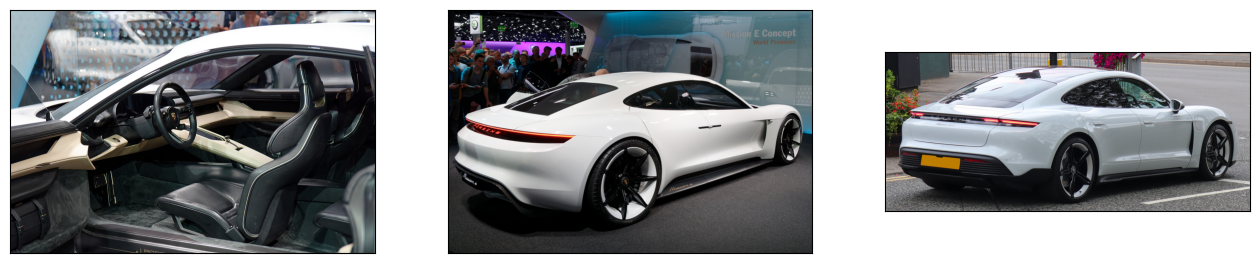

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)